In [589]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from cats2d.rd_cats2d import CATS2D
from pubchempy import *
from rdkit.Avalon import pyAvalonTools
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors, MACCSkeys, GraphDescriptors, Lipinski, QED, rdMolDescriptors, Fragments, FragmentMatcher
from rdkit.Chem.EState.EState_VSA import VSA_EState_
from statistics import mean
from tqdm import tqdm

In [590]:
import sklearn
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error

In [591]:
df = pd.read_csv('final_regression_dataset.csv')
df.head()

,SMILES,Activity,Source,Agglomeration,SMILES_uncharge,FORMAL_CHARGE_unch
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,['B3DB'],False,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,0
1,OCC(O)C(O)C(O)C(O)CO,-1.60,['B3DB'],False,OCC(O)C(O)C(O)C(O)CO,0
2,CC(=O)Nc1cccc(-c2csc(N=C(N)N)n2)c1,-1.57,['B3DB'],False,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,0
3,O=C(O)c1nc2ccc(C(F)(F)F)cc2nc1NCc1ccc(C(F)(F)F...,-1.57,['B3DB'],False,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,['B3DB'],False,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,0


In [592]:
df = df[['SMILES_uncharge', 'Activity']]


In [604]:
df = df.rename(columns={'SMILES_uncharge':'SMILES', 'logBB':'Activity'})
df.head()

,SMILES,Activity
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60
1,OCC(O)C(O)C(O)C(O)CO,-1.60
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54


### QED and Crippen modules

In [614]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    qed_vector = QED.properties(mol)
    df.at[i, 'MW'] = round(qed_vector[0], 2)
    df.at[i, 'AlogP'] = round(qed_vector[1], 2)
    df.at[i, '#HBA'] = qed_vector[2]
    df.at[i, '#HBD'] = qed_vector[3]
    df.at[i, 'PSA'] = qed_vector[4]
    df.at[i, '#ROTB'] = qed_vector[5]
    df.at[i, '#ALERTS'] = qed_vector[7]
    
    df.at[i, 'MlogP'] = round(Crippen.MolLogP(mol), 2)
    df.at[i, '#MR'] = round(Crippen.MolMR(mol), 2)
    
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,38.20
1,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,38.20
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,1.67,4.0,3.0,106.39,3.0,2.0,1.67,77.32
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,4.98,5.0,2.0,75.11,4.0,1.0,4.98,90.27
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,-5.60,17.0,8.0,285.14,9.0,1.0,-5.60,101.05


### Lipinski module

In [615]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, '#HeavyAtoms'] = Lipinski.HeavyAtomCount(mol)
    df.at[i, '#NHOH'] = Lipinski.NHOHCount(mol)
    df.at[i, '#NO'] = Lipinski.NOCount(mol)
    df.at[i, '#AromaticCarbocycles'] = Lipinski.NumAromaticCarbocycles(mol)
    df.at[i, '#AromaticHeterocycles'] = Lipinski.NumAromaticHeterocycles(mol)
    df.at[i, '#Heteroatoms'] = Lipinski.NumHeteroatoms(mol)
    
df.head()

### Descriptors module

In [616]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'Morgan2'] =  round(Descriptors.FpDensityMorgan2(mol), 2)
    df.at[i, 'Morgan3'] =  round(Descriptors.FpDensityMorgan3(mol), 2)
    df.at[i, 'HeavyAtomMW'] =  round(Descriptors.HeavyAtomMolWt(mol), 2)
    df.at[i, 'MaxPartialCharge'] = Descriptors.MaxPartialCharge(mol)
    df.at[i, 'MinPartialCharge'] = Descriptors.MinPartialCharge(mol)
    df.at[i, '#ValenceElectrons'] = Descriptors.NumValenceElectrons(mol)
    
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,#NO,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,6.0,0.0,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0
1,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,6.0,0.0,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,1.67,4.0,3.0,106.39,3.0,2.0,1.67,...,6.0,1.0,1.0,7.0,2.21,2.89,262.23,0.220748,-0.369771,98.0
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,4.98,5.0,2.0,75.11,4.0,1.0,4.98,...,5.0,2.0,1.0,11.0,1.45,2.00,404.21,0.415990,-0.476407,152.0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,-5.60,17.0,8.0,285.14,9.0,1.0,-5.60,...,18.0,0.0,0.0,20.0,1.35,1.85,518.28,0.396945,-0.387946,200.0


### GraphDescriptors module

In [617]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'BertzCT'] = round(GraphDescriptors.BertzCT(mol), 2)
    df.at[i, 'Kappa1'] = round(GraphDescriptors.Kappa1(mol), 2)
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons,BertzCT,Kappa1
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0,104.61,11.76
1,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0.0,6.0,0.92,1.08,168.06,0.110579,-0.393579,74.0,104.61,11.76
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,1.67,4.0,3.0,106.39,3.0,2.0,1.67,...,1.0,7.0,2.21,2.89,262.23,0.220748,-0.369771,98.0,630.55,13.03
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,4.98,5.0,2.0,75.11,4.0,1.0,4.98,...,1.0,11.0,1.45,2.00,404.21,0.415990,-0.476407,152.0,1062.11,20.37
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,-5.60,17.0,8.0,285.14,9.0,1.0,-5.60,...,0.0,20.0,1.35,1.85,518.28,0.396945,-0.387946,200.0,911.18,29.12


### Fragment descriptors

In [621]:
uniq_el = set([])
uniq_bond = set([])
for mol_sm in tqdm(df['SMILES']):
    mol_sm_rd = Chem.MolFromSmiles(mol_sm)
    list_atomic = [x.GetSymbol() for x in mol_sm_rd.GetAtoms()]
    uniq_el = uniq_el | set(list_atomic)
    list_bond = [str(x.GetBondType()) for x in Chem.MolFromSmiles(mol_sm).GetBonds()]
    uniq_bond = uniq_bond | set(list_bond)
    
uniq_el = list(uniq_el) 
print(uniq_el)
np.save('BBB_uniq_el', np.array(uniq_el))
uniq_bond = list(uniq_bond) 
print(uniq_bond)

100%|████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:00<00:00, 1812.44it/s]

['F', 'I', 'C', 'N', 'Br', 'S', 'P', 'Cl', 'B', 'O']
['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC']


In [622]:
list_dop_descript = []
for mol_i in tqdm(df['SMILES']):
    mol_sm = Chem.MolFromSmiles(mol_i)
    
    num_atom = mol_sm.GetNumAtoms()

    # the amount of each element in the molecule
    list_atomic_num = [x.GetSymbol() for x in mol_sm.GetAtoms()]
    list_count_atom = [list_atomic_num.count(x) for x in uniq_el]

    # number of each bond type and bond analysis
    list_bond = list(np.array([x.GetBondType() for x in mol_sm.GetBonds()], dtype=str))
    list_count_bond = [list_bond.count(x) for x in uniq_bond]
    

    AlCOO = Fragments.fr_Al_COO(mol_sm)
    AlOH = Fragments.fr_Al_OH(mol_sm)
    AlOHnt = Fragments.fr_Al_OH_noTert(mol_sm)
    ArN = Fragments.fr_ArN(mol_sm) 
    ArCOO = Fragments.fr_Ar_COO(mol_sm)
    Ar_N = Fragments.fr_Ar_N(mol_sm) 
    ArNH = Fragments.fr_Ar_NH(mol_sm) 
    ArOH = Fragments.fr_Ar_OH(mol_sm)
    COO = Fragments.fr_COO(mol_sm)
    CO = Fragments.fr_C_O(mol_sm)
    CO_clean = Fragments.fr_C_O_noCOO(mol_sm)
    CS = Fragments.fr_C_S(mol_sm)
    HOCCN = Fragments.fr_HOCCN(mol_sm)
    Imine = Fragments.fr_Imine(mol_sm)
    NHtert = Fragments.fr_NH0(mol_sm)
    NHsec = Fragments.fr_NH1(mol_sm)
    NHpri = Fragments.fr_NH2(mol_sm)
    NO = Fragments.fr_N_O(mol_sm) 
    XCCNR = Fragments.fr_Ndealkylation1(mol_sm) 
    TACA = Fragments.fr_Ndealkylation2(mol_sm) 
    Npyrrl = Fragments.fr_Nhpyrrole(mol_sm)
    SH = Fragments.fr_SH(mol_sm)
    Ald = Fragments.fr_aldehyde(mol_sm)
    Alk_carb = Fragments.fr_alkyl_carbamate(mol_sm) 
    Alk_hal = Fragments.fr_alkyl_halide(mol_sm)
    Alk_oxid = Fragments.fr_allylic_oxid(mol_sm)
    Amide = Fragments.fr_amide(mol_sm)
    Amidine = Fragments.fr_amidine(mol_sm)
    Aniline = Fragments.fr_aniline(mol_sm)
    Ar_methyl = Fragments.fr_aryl_methyl(mol_sm) 
    Azide = Fragments.fr_azide(mol_sm)
    Azo = Fragments.fr_azo(mol_sm)
    Barb = Fragments.fr_barbitur(mol_sm)
    Benz = Fragments.fr_benzene(mol_sm)
    BenzD = Fragments.fr_benzodiazepine(mol_sm)
    Bicycl = Fragments.fr_bicyclic(mol_sm)
    Diazo = Fragments.fr_diazo(mol_sm)
    DHpyridine = Fragments.fr_dihydropyridine(mol_sm)
    Epoxide = Fragments.fr_epoxide(mol_sm)
    Ester = Fragments.fr_ester(mol_sm)
    EtherO = Fragments.fr_ether(mol_sm)
    Furan = Fragments.fr_furan(mol_sm)
    Guanid = Fragments.fr_guanido(mol_sm)
    Hal = Fragments.fr_halogen(mol_sm)
    Hdrzine = Fragments.fr_hdrzine(mol_sm)
    Hdrzone = Fragments.fr_hdrzone(mol_sm)
    Imidazole = Fragments.fr_imidazole(mol_sm)
    Imide = Fragments.fr_imide(mol_sm)
    RNCO = Fragments.fr_isocyan(mol_sm)
    RNCS = Fragments.fr_isothiocyan(mol_sm)
    Ket = Fragments.fr_ketone(mol_sm)
    Ket2 = Fragments.fr_ketone_Topliss(mol_sm)
    Lactam = Fragments.fr_lactam(mol_sm)
    Lactone = Fragments.fr_lactone(mol_sm)
    OMe = Fragments.fr_methoxy(mol_sm)
    Morphlne = Fragments.fr_morpholine(mol_sm)
    RCN = Fragments.fr_nitrile(mol_sm)
    Nitro = Fragments.fr_nitro(mol_sm)
    NitroAr = Fragments.fr_nitro_arom(mol_sm)
    NitroArno = Fragments.fr_nitro_arom_nonortho(mol_sm)
    RNO = Fragments.fr_nitroso(mol_sm)
    Oxaz = Fragments.fr_oxazole(mol_sm)
    Oxime = Fragments.fr_oxime(mol_sm)
    paraHX = Fragments.fr_para_hydroxylation(mol_sm)
    PhOH = Fragments.fr_phenol(mol_sm)
    PhOHno = Fragments.fr_phenol_noOrthoHbond(mol_sm)
    PAcide = Fragments.fr_phos_acid(mol_sm)
    PEster = Fragments.fr_phos_ester(mol_sm)
    Piprdn = Fragments.fr_piperdine(mol_sm)
    Piprzn = Fragments.fr_piperzine(mol_sm)
    Priamide = Fragments.fr_priamide(mol_sm)
    Prisulfamd = Fragments.fr_prisulfonamd(mol_sm)
    PyrRing = Fragments.fr_pyridine(mol_sm)
    Nquat = Fragments.fr_quatN(mol_sm)
    Sether = Fragments.fr_sulfide(mol_sm)
    Sulfamd = Fragments.fr_sulfonamd(mol_sm)
    Sulfone = Fragments.fr_sulfone(mol_sm)
    TermCHCH = Fragments.fr_term_acetylene(mol_sm)
    Tetrazol = Fragments.fr_tetrazole(mol_sm)
    Thiazole = Fragments.fr_thiazole(mol_sm)
    RSCN = Fragments.fr_thiocyan(mol_sm)
    Thioph = Fragments.fr_thiophene(mol_sm)
    UNb_alk = Fragments.fr_unbrch_alkane(mol_sm)
    Urea = Fragments.fr_urea(mol_sm)

    
    list_desc = list_count_atom + list_count_bond + [num_atom, 
               AlCOO, AlOH, AlOHnt, ArN, ArCOO, Ar_N, ArNH, ArOH, COO, CO, CO_clean, CS, HOCCN,
               Imine, NHtert, NHsec, NHpri, NO, XCCNR, TACA, Npyrrl, SH, Ald, Alk_carb, Alk_hal,
               Alk_oxid, Amide, Amidine, Aniline, Ar_methyl, Azide, Azo, Barb, Benz, BenzD,
               Bicycl, Diazo, DHpyridine, Epoxide, Ester, EtherO, Furan, Guanid, Hal, Hdrzine,
               Hdrzone, Imidazole, Imide, RNCO, RNCS, Ket, Ket2, Lactam, Lactone, OMe, Morphlne,
               RCN, Nitro, NitroAr, NitroArno, RNO, Oxaz, Oxime, paraHX, PhOH, PhOHno, PAcide,
               PEster, Piprdn, Piprzn, Priamide, Prisulfamd, PyrRing, Nquat, Sether, Sulfamd,
               Sulfone, TermCHCH, Tetrazol, Thiazole, RSCN, Thioph, UNb_alk, Urea]
    list_dop_descript.append(list_desc)
    
list_dop_descript = np.array(list_dop_descript)

100%|█████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:01<00:00, 830.74it/s]


In [623]:
list_dop_descript.shape

(1130, 99)

In [624]:
dop_desc_name = uniq_el + uniq_bond + ['num_atom', 
            'AlCOO', 'AlOH', 'AlOHnt', 'ArN', 'ArCOO', 'Ar_N', 'ArNH', 'ArOH', 'COO',
            'CO', 'CO_clean', 'CS', 'HOCCN',
            'Imine', 'NHtert', 'NHsec', 'NHpri', 'NO', 'XCCNR', 'TACA', 'Npyrrl', 'SH',
            'Ald', 'Alk_carb', 'Alk_hal',
            'Alk_oxid', 'Amide', 'Amidine', 'Aniline', 'Ar_methyl', 'Azide', 'Azo', 'Barb', 'Benz', 'BenzD',
            'Bicycl', 'Diazo', 'DHpyridine', 'Epoxide', 'Ester',
            'EtherO', 'Furan', 'Guanid', 'Hal', 'Hdrzine',
            'Hdrzone', 'Imidazole', 'Imide', 'RNCO', 'RNCS', 'Ket',
            'Ket2', 'Lactam', 'Lactone', 'OMe', 'Morphlne',
            'RCN', 'Nitro', 'NitroAr', 'NitroArno', 'RNO', 'Oxaz', 'Oxime', 'paraHX', 'PhOH', 'PhOHno', 'PAcide',
            'PEster', 'Piprdn', 'Piprzn', 'Priamide', 'Prisulfamd', 'PyrRing', 'Nquat', 'Sether', 'Sulfamd',
            'Sulfone', 'TermCHCH', 'Tetrazol', 'Thiazole', 'RSCN', 'Thioph', 'UNb_alk', 'Urea']

dop_desc_name_new = [str(x) + '_dop' for x in dop_desc_name]
print(dop_desc_name_new)

dop_mass_one = list_dop_descript.copy()
dop_mass_one[dop_mass_one != 0] = 1
dop_mass_one = np.sum(dop_mass_one, axis=0)

['F_dop', 'I_dop', 'C_dop', 'N_dop', 'Br_dop', 'S_dop', 'P_dop', 'Cl_dop', 'B_dop', 'O_dop', 'SINGLE_dop', 'DOUBLE_dop', 'TRIPLE_dop', 'AROMATIC_dop', 'num_atom_dop', 'AlCOO_dop', 'AlOH_dop', 'AlOHnt_dop', 'ArN_dop', 'ArCOO_dop', 'Ar_N_dop', 'ArNH_dop', 'ArOH_dop', 'COO_dop', 'CO_dop', 'CO_clean_dop', 'CS_dop', 'HOCCN_dop', 'Imine_dop', 'NHtert_dop', 'NHsec_dop', 'NHpri_dop', 'NO_dop', 'XCCNR_dop', 'TACA_dop', 'Npyrrl_dop', 'SH_dop', 'Ald_dop', 'Alk_carb_dop', 'Alk_hal_dop', 'Alk_oxid_dop', 'Amide_dop', 'Amidine_dop', 'Aniline_dop', 'Ar_methyl_dop', 'Azide_dop', 'Azo_dop', 'Barb_dop', 'Benz_dop', 'BenzD_dop', 'Bicycl_dop', 'Diazo_dop', 'DHpyridine_dop', 'Epoxide_dop', 'Ester_dop', 'EtherO_dop', 'Furan_dop', 'Guanid_dop', 'Hal_dop', 'Hdrzine_dop', 'Hdrzone_dop', 'Imidazole_dop', 'Imide_dop', 'RNCO_dop', 'RNCS_dop', 'Ket_dop', 'Ket2_dop', 'Lactam_dop', 'Lactone_dop', 'OMe_dop', 'Morphlne_dop', 'RCN_dop', 'Nitro_dop', 'NitroAr_dop', 'NitroArno_dop', 'RNO_dop', 'Oxaz_dop', 'Oxime_dop', 'pa

In [625]:
print(dop_mass_one.shape)
print(dop_mass_one)

(99,)
[ 177   14 1130  951   40  196    2  178    1  886 1123  799   49  920
 1130   53  250  203   67   19  411  109   83   72  490  446    5   20
  104  788  517  172    9  140  199  109    1    0    9   98  113  313
   14  376  206    3    0   19  797    9  503    0    3    7   83  470
   29   53  361    7    3   89   33    0    0  100   84    1   20  162
   12   40   38    6    6    2    4    7  191   80   78    2    2  243
   91   36    0  137    4   55   36   11    6    6   34    0   20  115
   43]


C:\Users\alley\AppData\Local\Temp\ipykernel_24520\1281551338.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(len(dop_mass_one)), np.log10(np.sort(dop_mass_one)))


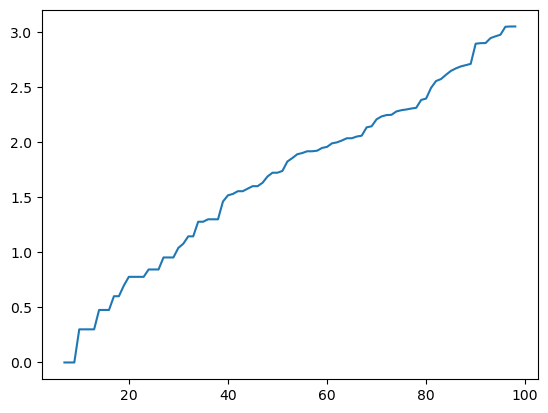

In [626]:
plt.plot(np.arange(len(dop_mass_one)), np.log10(np.sort(dop_mass_one)))

In [627]:
w = np.where(dop_mass_one > 20)[0]
df_dop_desc = pd.DataFrame(list_dop_descript, columns=np.array(dop_desc_name_new, dtype=str)) #first set
print('dop desc', df_dop_desc.shape)
print('left dop feat', len(w))
df_dop_desc = df_dop_desc.iloc[:, w]
print('dop desc new', df_dop_desc.shape)

dop desc (1130, 99)
left dop feat 60
dop desc new (1130, 60)


In [628]:
df_dop_desc['Activity'] = df['Activity'].values
columns = list(df_dop_desc.columns.values)
columns = [columns[-1]] + columns[:-1]
df_dop_desc = df_dop_desc.loc[:, columns]
df_dop_desc.head(5)

,Activity,F_dop,C_dop,N_dop,Br_dop,S_dop,Cl_dop,O_dop,SINGLE_dop,DOUBLE_dop,...,PhOHno_dop,Piprdn_dop,Piprzn_dop,Priamide_dop,PyrRing_dop,Sether_dop,Sulfamd_dop,Thiazole_dop,UNb_alk_dop,Urea_dop
0,-1.60,0,6,0,0,0,0,6,11,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.60,0,6,0,0,0,0,6,11,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.57,0,12,5,0,1,0,1,7,2,...,0,0,0,0,0,0,0,1,0,0
3,-1.57,6,18,3,0,0,0,2,13,1,...,0,0,0,0,0,0,0,0,0,0
4,-1.54,0,14,1,0,2,0,17,30,5,...,0,0,0,0,0,0,0,0,0,0


In [629]:
df_corr = df_dop_desc.corr()
df_corr

,Activity,F_dop,C_dop,N_dop,Br_dop,S_dop,Cl_dop,O_dop,SINGLE_dop,DOUBLE_dop,...,PhOHno_dop,Piprdn_dop,Piprzn_dop,Priamide_dop,PyrRing_dop,Sether_dop,Sulfamd_dop,Thiazole_dop,UNb_alk_dop,Urea_dop
Activity,1.000000,0.132659,-0.115424,-0.317676,0.041653,-0.144286,0.066439,-0.358881,-0.156094,-0.328633,...,-0.105699,0.117062,-0.042404,-0.079305,-0.112878,-0.184256,-0.140909,-0.041100,-0.058806,-0.016183
F_dop,0.132659,1.000000,-0.031639,-0.062951,0.091378,-0.080870,0.011799,-0.084482,0.021732,-0.107442,...,-0.060898,0.050298,0.043820,-0.050999,0.029593,-0.042927,-0.041085,-0.006925,0.006537,-0.014285
C_dop,-0.115424,-0.031639,1.000000,0.415670,-0.069109,0.056793,-0.101350,0.608259,0.855933,0.485875,...,0.208148,0.303489,0.184743,-0.015058,0.070356,-0.000780,0.044282,-0.010201,0.030876,-0.096273
N_dop,-0.317676,-0.062951,0.415670,1.000000,0.007699,0.207335,0.034524,0.123277,0.334695,0.291575,...,-0.067350,0.031991,0.274026,0.014726,0.197390,0.182373,0.076630,0.167224,0.001854,0.018527
Br_dop,0.041653,0.091378,-0.069109,0.007699,1.000000,-0.026637,-0.016929,-0.072892,-0.010766,-0.009757,...,-0.042279,0.000806,0.030498,-0.030920,0.006676,0.029815,0.010723,-0.030593,0.005549,-0.035023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sether_dop,-0.184256,-0.042927,-0.000780,0.182373,0.029815,0.478552,-0.073413,-0.036803,0.012310,-0.021208,...,-0.022429,-0.015103,-0.006487,-0.039718,0.028125,1.000000,-0.041032,0.029907,0.214134,-0.044988
Sulfamd_dop,-0.140909,-0.041085,0.044282,0.076630,0.010723,0.369915,-0.009939,0.078303,0.037754,0.122790,...,0.008527,0.028019,0.094457,-0.031853,-0.024403,-0.041032,1.000000,-0.003252,-0.017416,0.016595
Thiazole_dop,-0.041100,-0.006925,-0.010201,0.167224,-0.030593,0.377619,-0.033285,-0.079867,-0.040119,-0.051183,...,-0.003235,0.061224,-0.033174,-0.030507,-0.048380,0.029907,-0.003252,1.000000,0.000385,0.017335
UNb_alk_dop,-0.058806,0.006537,0.030876,0.001854,0.005549,0.062461,-0.061195,0.057278,0.073437,-0.011485,...,0.043108,-0.069790,-0.005756,-0.043570,0.006534,0.214134,-0.017416,0.000385,1.000000,0.006375


In [630]:
act_row = df_corr.iloc[0]
print(act_row.sort_values().to_string())

O_dop           -0.358881
DOUBLE_dop      -0.328633
N_dop           -0.317676
Npyrrl_dop      -0.270885
ArNH_dop        -0.270885
Ar_N_dop        -0.260823
COO_dop         -0.234339
NHtert_dop      -0.218557
NHsec_dop       -0.212159
CO_dop          -0.211120
num_atom_dop    -0.208471
AlOHnt_dop      -0.206161
AlCOO_dop       -0.205525
Furan_dop       -0.203782
AlOH_dop        -0.187545
Sether_dop      -0.184256
CO_clean_dop    -0.165883
SINGLE_dop      -0.156094
NHpri_dop       -0.155483
Amide_dop       -0.146814
Nitro_dop       -0.145346
S_dop           -0.144286
Sulfamd_dop     -0.140909
Guanid_dop      -0.136672
Imidazole_dop   -0.122243
C_dop           -0.115424
PyrRing_dop     -0.112878
PhOH_dop        -0.111371
ArOH_dop        -0.109617
PhOHno_dop      -0.105699
Imine_dop       -0.090496
AROMATIC_dop    -0.082795
EtherO_dop      -0.082406
Priamide_dop    -0.079305
ArN_dop         -0.069594
Ket_dop         -0.059037
UNb_alk_dop     -0.058806
Bicycl_dop      -0.055035
Alk_oxid_dop

In [631]:
fragments_list = np.load('BBB_features.npy')
fgraments_list = fragments_list[-474:]
fgraments_list

array(['cc-c(c)ccc', 'ccccs', 'ccccN', 'cccnc', 'cccc(c)-cn', 'csccn',
       'c1cscn1', 'ccsc(n)N', 'cncN', 'cnc(c)-c', 'cccc-c(c)n', 'ccncN',
       'ccc(c)-c(c)n', 'ccc-c(c)nc', 'cccncN', 'ccc(c)-cnc',
       'cnc(c)-c(c)c', 'ccccNC', 'cc(c)CN', 'cnccn', 'ccccn', 'cccc(c)nc',
       'cncNCC', 'cccc(c)CN', 'cnc(c)cn', 'ccccnc', 'ccc(cc)CN',
       'cnc(c)c(c)n', 'cccncNC', 'ccccncN', 'CCO', 'CCOC', 'COC(C)O',
       'CCCO', 'OCCO', 'CCC(C)O', 'CC[C@@H](C)O', 'CCCOC', 'CO[C@H](C)C',
       'CCCOCC', 'cccc(c)N', 'ccccc(c)N', 'cc(-c)ccN', 'ccccc(c)O',
       'cccc(c)CC', 'cccc(c)OC', 'CCC(C)C', 'ccc(c)CCC', 'ccc(c)OCC',
       'cc(c)CCCC', 'CCC(C)CC', 'cc(c)OCCC', 'CCCCO', 'CCC(C)COc',
       'cc(O)cccC', 'cccco', 'cccc(c)cc', 'ccc(cc)OC', 'ccccNCC',
       'cccc(c)NC', 'ccc(N)nc', 'ccccN(C)C', 'CNCCN', 'CCN(C)C',
       'ccc(c)CNC', 'ccc(c)NCC', 'cccncc', 'ccc(n)NCC', 'cc(n)N(C)CC',
       'CNCCN(c)C', 'cccN(C)CC', 'ccc(c)N(C)C', 'CCNCCN', 'CCNCC',
       'CCN(C)CC', 'cc(c)CNCC', 'cc(c

In [632]:
list_main_descript = []
for mol_i in tqdm(df['SMILES']):
    mol_sm = Chem.MolFromSmiles(mol_i)
    mol_frags_list = []
    for ii in range(len(fgraments_list)):
        p = FragmentMatcher.FragmentMatcher()
        p.Init(fgraments_list[ii])
        mol_frags_list.append(len(p.GetMatches(mol_sm)))
    list_main_descript.append(mol_frags_list)

list_main_descript = np.array(list_main_descript)
print(list_main_descript.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:16<00:00, 69.56it/s]

(1130, 474)


In [633]:
df_main_desc = pd.DataFrame(list_main_descript, columns=fgraments_list)
df_main_desc.describe()

,cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,cnc(c)-c,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,...,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000
mean,0.339823,0.071681,0.749558,1.146018,0.132743,0.040708,0.030973,0.023894,0.177876,0.055752,...,0.024779,0.062832,0.022124,0.043363,0.044248,0.038938,0.122124,0.085841,0.283186,0.321239
std,1.515058,0.407192,1.329679,2.017397,0.725402,0.222967,0.178360,0.179446,0.562519,0.296850,...,0.161114,0.355320,0.147152,0.277397,0.294303,0.253036,0.679412,0.549316,1.000169,0.635801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,4.000000,8.000000,14.000000,8.000000,2.000000,2.000000,2.000000,6.000000,3.000000,...,2.000000,4.000000,1.000000,2.000000,2.000000,2.000000,6.000000,4.000000,7.000000,3.000000


In [634]:
df_main_desc['Activity'] = df['Activity'].values
columns = list(df_main_desc.columns.values)
columns = [columns[-1]] + columns[:-1]
df_main_desc = df_main_desc.loc[:, columns]
df_main_desc.head(5)

,Activity,cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
0,-1.60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.57,2,2,3,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,-1.57,0,0,0,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,6,0
4,-1.54,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [635]:
df_corr = df_main_desc.corr()
df_corr

,Activity,cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
Activity,1.000000,-0.038669,-0.002208,0.019223,-0.208344,-0.037169,-0.025967,-0.041100,-0.030314,-0.140407,...,0.127612,0.122970,0.131041,0.123576,0.111165,0.066567,0.018809,0.017863,0.121911,0.097326
cc-c(c)ccc,-0.038669,1.000000,0.026524,0.090647,0.081990,0.247442,0.006209,0.006904,0.009203,0.022548,...,-0.034527,-0.039698,-0.033752,-0.035093,-0.033752,-0.034546,-0.026585,-0.035082,0.003073,0.000592
ccccs,-0.002208,0.026524,1.000000,0.083899,0.178096,0.111694,0.699523,0.506018,0.388686,0.037092,...,0.161920,0.140257,0.180462,-0.027543,-0.026490,-0.027113,-0.018864,-0.019614,-0.036838,0.006773
ccccN,0.019223,0.090647,0.083899,1.000000,-0.026309,-0.011418,-0.025334,-0.030754,-0.015732,0.075005,...,-0.061967,-0.077274,-0.057667,0.344048,0.322587,-0.086823,-0.048472,-0.066341,-0.062511,0.201065
cccnc,-0.208344,0.081990,0.178096,-0.026309,1.000000,0.358973,0.201409,0.041575,0.022161,0.295540,...,-0.030217,-0.004161,-0.022826,-0.085714,-0.085483,-0.087494,-0.102200,-0.088850,-0.041582,0.067671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCC(c)[C@@H](C)C,0.066567,-0.034546,-0.027113,-0.086823,-0.087494,-0.028185,-0.028120,-0.026747,-0.020508,-0.048703,...,-0.023688,-0.027236,-0.023157,-0.024076,-0.023157,1.000000,-0.027685,-0.024068,-0.036609,-0.061302
CCCCNCN,0.018809,-0.026585,-0.018864,-0.048472,-0.102200,-0.032922,-0.032847,-0.031242,-0.023955,-0.056890,...,-0.011486,-0.017137,-0.027049,-0.028123,-0.027049,-0.027685,1.000000,0.899842,-0.033994,-0.029385
CC(C)CNCN,0.017863,-0.035082,-0.019614,-0.066341,-0.088850,-0.028621,-0.014092,-0.009080,-0.020826,-0.049458,...,-0.024055,-0.027658,-0.023515,-0.024450,-0.023515,-0.024068,0.899842,1.000000,-0.044285,-0.046056
C[X],0.121911,0.003073,-0.036838,-0.062511,-0.041582,-0.029883,-0.039824,-0.034317,-0.008123,-0.018767,...,0.115819,0.094446,0.095812,-0.018760,-0.018534,-0.036609,-0.033994,-0.044285,1.000000,-0.063789


In [636]:
del df_main_desc['Activity']

In [637]:
df_full = pd.concat([df_dop_desc, df_main_desc], axis=1)
df_full.shape

(1130, 535)

In [638]:
del df_full['Activity']

In [639]:
df = pd.concat([df, df_full], axis=1)
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0,0,0,0,0,0,0,0,0,0
1,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0,0,0,0,0,0,0,0,0,0
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,1.67,4.0,3.0,106.39,3.0,2.0,1.67,...,0,0,0,0,0,0,0,0,0,0
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,4.98,5.0,2.0,75.11,4.0,1.0,4.98,...,0,0,0,0,0,0,0,0,6,0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,-5.60,17.0,8.0,285.14,9.0,1.0,-5.60,...,0,0,0,0,0,0,0,0,0,0


### Estate_VSA

In [640]:
def generate_estate_fpts(data):
    estate_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        estatefpts = VSA_EState_(mol)
        estate_fpts.append(estatefpts)
    return np.array(estate_fpts)

In [641]:
estate_fpts = generate_estate_fpts(df['SMILES'])

100%|████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:00<00:00, 1786.68it/s]


In [642]:
estate_fpts.shape

(1130, 10)

In [643]:
for i, row in df.iterrows():
    for j in range(estate_fpts.shape[1]):
        df.at[i, f'E_{j+1}'] = estate_fpts[i][j]
    
df.head()

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0.000000,0.000000,52.176914,0.000000,0.000000,0.000000,-6.391944,-1.451636,0.00000,0.000000
1,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0.000000,0.000000,52.176914,0.000000,0.000000,0.000000,-6.391944,-1.451636,0.00000,0.000000
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,1.67,4.0,3.0,106.39,3.0,2.0,1.67,...,0.000000,19.201681,5.078830,12.969815,-0.134704,7.406556,0.000000,1.464642,0.00000,1.346513
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,4.98,5.0,2.0,75.11,4.0,1.0,4.98,...,76.408470,19.134407,11.887089,-2.200566,-1.765334,6.596278,-9.113484,-0.113526,0.00000,0.000000
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,-5.60,17.0,8.0,285.14,9.0,1.0,-5.60,...,84.727417,11.389837,53.051470,0.000000,-0.728697,-1.556118,-16.981647,-1.057560,-10.01137,0.000000


In [647]:
df.to_csv('fragments_refined_regression.csv', index=False)

### Avalon

In [648]:
def generate_AVfpts(data):
    Avalon_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        Avalon_fpts.append(avfpts)
    return np.array(Avalon_fpts)

In [649]:
Avalon_fpts = generate_AVfpts(df['SMILES'])

100%|████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:00<00:00, 1372.10it/s]


In [650]:
Avalon_fpts.shape

(1130, 512)

In [651]:
for i, row in df.iterrows():
    for j in range(Avalon_fpts.shape[1]):
        df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]
    
df.head()

C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3442778819.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3442778819.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3442778819.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3442778819.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3442778819.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3442778819.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,A_503,A_504,A_505,A_506,A_507,A_508,A_509,A_510,A_511,A_512
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,1.67,4.0,3.0,106.39,3.0,2.0,1.67,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,4.98,5.0,2.0,75.11,4.0,1.0,4.98,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,-5.60,17.0,8.0,285.14,9.0,1.0,-5.60,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [653]:
df.to_csv('avalon_refined_regression.csv', index=False)

### MACCS

In [654]:
def generate_MACCS(data):
    MACCS_keys = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        maccs = list(MACCSkeys.GenMACCSKeys(mol).ToBitString())
        MACCS_keys.append(maccs)
    return np.array(MACCS_keys)

In [655]:
MACCS_keys = generate_MACCS(df['SMILES'])

In [656]:
for i, row in df.iterrows():
    for j in range(MACCS_keys.shape[1]):
        df.at[i, f'MAC_{j+1}'] =  MACCS_keys[i][j]
    
df.head()

In [658]:
df.to_csv('maccs_refined_regression.csv', index=False)

### ECFP6

In [659]:
def generate_ECFP6(data):
    ECFP6_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        ecfp6 = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 3)
        ECFP6_fpts.append(ecfp6)
    return np.array(ECFP6_fpts)

In [660]:
ECFP6_fpts = generate_ECFP6(df['SMILES'])

In [661]:
for i, row in df.iterrows():
    for j in range(ECFP6_fpts.shape[1]):
        df.at[i, f'ECFP6_{j+1}'] =  ECFP6_fpts[i][j]
df.head()

In [662]:
df.to_csv('ecfp6_refined_regression.csv', index=False)

### CATS2D

In [663]:
cats = CATS2D()

In [664]:
def generate_cats2d(data):
    cats2d = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        mol_cats = cats.getCATs2D(mol)
        cats2d.append(mol_cats)
    return np.array(cats2d)

In [665]:
cats2d = generate_cats2d(df['SMILES'])

In [666]:
for i, row in df.iterrows():
    for j in range(cats2d.shape[1]):
        df.at[i, f'CATS_{j+1}'] = cats2d[i][j]
    
df.head()

In [ ]:
df.to_csv('cats2d_refined_regression.csv', index=False)

### PubChem

In [671]:
def generate_pubchem(data):
    rows_to_del = []
    pubchem_features = []
    idx = 0
    for smi in (list(data)):
        try:
            cid = get_cids(smi, 'smiles')[0]
            print(cid)
            if cid == 0:
                rows_to_del.append(idx)
            else:
                features_dict = Compound.from_cid(cid).to_dict()
                descriptors = [features_dict['atom_stereo_count'], features_dict['bond_stereo_count'],
                               features_dict['complexity'], features_dict['covalent_unit_count'],
                               features_dict['isotope_atom_count']
                              ]
                fingerprints = [int(fp) for fp in list(features_dict['cactvs_fingerprint'])]
                pubchem_features.append(descriptors + fingerprints)
        except:
            rows_to_del.append(idx)
            print('hey')
        idx = idx + 1
    return np.array(pubchem_features), rows_to_del

In [672]:
pubchem_features, rows_to_del = generate_pubchem(df['SMILES'])

6251
453
14022511
86287487
75212846
14022519
536278
0
0
0
468305
4112
0
2284
36462
126941
5291
676643
17748716
182017
3308
156861560
152743279
2756
3230
135400189
131584
60949
9864646
5166
2050078
978
0
12032949
142067
60823
0
10384745
1779
135422442
2083
135398744
14022522
5312149
3715
0
21675832
12296938
16655839
456389
135529433
1497794
176407
hey
3033
135483777
135398739
162244
53394319
35025677
66724
0
3001055
0
54429646
9883333
5039
0
30322
0
60877
3062
5718
hey
hey
11957394
12889418
14022509
57390958
24894028
3600
5284514
0
13646638
0
5355
338
4539
2443
31101
0
4375468
22407
hey
51671
60857
3579812
3717450
5978
5731
3348
0
4330618
16207207
0
0
11003252
4687521
15186924
10063598
71927
0
6918479
86765134
2662
60652
5362391
15986375
9950176
441243
4411
197322
4451
0
37614
10324755
2249
4893
3488
0
6426129
19349126
9846311
0
77870
0
5330
33039
5044
1691
31703
hey
hey
hey
hey
135398513
50287
1268111
44416780
9923127
56839178
2833
0
6047
0
14840722
5385314
44579173
0
22184393
0
643460

In [673]:
for i in rows_to_del:
    df = df.drop(labels=[i], axis=0)

In [674]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 0 to 1129
Columns: 1081 entries, SMILES to A_512
dtypes: float64(546), int32(534), object(1)
memory usage: 5.9+ MB


In [675]:
pubchem_features

array([[4.00e+00, 0.00e+00, 1.05e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [4.00e+00, 0.00e+00, 1.05e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 3.58e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [1.00e+00, 0.00e+00, 7.08e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [6.00e+00, 0.00e+00, 1.18e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [1.10e+01, 0.00e+00, 1.83e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

In [676]:
number = 0
for i, row in df.iterrows():
    for j in range(pubchem_features.shape[1]):
        df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
    number = number + 1
df.head()

C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
C:\Users\alley\AppData\Local\Temp\ipykernel_24520\3387665155.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,PUBCHEM_877,PUBCHEM_878,PUBCHEM_879,PUBCHEM_880,PUBCHEM_881,PUBCHEM_882,PUBCHEM_883,PUBCHEM_884,PUBCHEM_885,PUBCHEM_886
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,1.67,4.0,3.0,106.39,3.0,2.0,1.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,4.98,5.0,2.0,75.11,4.0,1.0,4.98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,-5.60,17.0,8.0,285.14,9.0,1.0,-5.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [678]:
df = df.head(862)
df

,SMILES,Activity,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,...,PUBCHEM_877,PUBCHEM_878,PUBCHEM_879,PUBCHEM_880,PUBCHEM_881,PUBCHEM_882,PUBCHEM_883,PUBCHEM_884,PUBCHEM_885,PUBCHEM_886
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OCC(O)C(O)C(O)C(O)CO,-1.60,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,-1.57,275.34,1.67,4.0,3.0,106.39,3.0,2.0,1.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,-1.57,415.29,4.98,5.0,2.0,75.11,4.0,1.0,4.98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,-1.54,543.48,-5.60,17.0,8.0,285.14,9.0,1.0,-5.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,CC1=NC(C2=CSC(NC(=N)N)=N2)=CN1,-0.04,222.28,1.15,4.0,4.0,103.47,2.0,2.0,1.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1030,ClC1=CC=CC(Cl)=C1N=C1NCCN1,0.12,230.10,2.17,2.0,2.0,36.42,1.0,0.0,2.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1031,O=C(O)CCCCON=C(C1=CC=CN=C1)C1=CC=CC(C(F)(F)F)=C1,-1.00,366.34,4.12,4.0,1.0,71.78,8.0,3.0,4.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1033,NC1CC1C1=CC=C(F)C=C1,0.81,151.18,1.64,1.0,1.0,26.02,1.0,0.0,1.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [679]:
activity = df['Activity']
del df['Activity']
df['Activity'] = activity
df.head()

C:\Users\alley\AppData\Local\Temp\ipykernel_24520\2550641588.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Activity'] = activity


,SMILES,MW,AlogP,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,...,PUBCHEM_878,PUBCHEM_879,PUBCHEM_880,PUBCHEM_881,PUBCHEM_882,PUBCHEM_883,PUBCHEM_884,PUBCHEM_885,PUBCHEM_886,Activity
0,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.60
1,OCC(O)C(O)C(O)C(O)CO,182.17,-3.59,6.0,6.0,121.38,5.0,0.0,-3.59,38.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.60
2,CC(=O)NC1=CC=CC(C2=CSC(N=C(N)N)=N2)=C1,275.34,1.67,4.0,3.0,106.39,3.0,2.0,1.67,77.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.57
3,O=C(O)C1=NC2=CC=C(C(F)(F)F)C=C2N=C1NCC1=CC=C(C...,415.29,4.98,5.0,2.0,75.11,4.0,1.0,4.98,90.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.57
4,CC(=O)NC1C(O)OC(COS(=O)(=O)O)C(OC2OC(COS(=O)(=...,543.48,-5.60,17.0,8.0,285.14,9.0,1.0,-5.60,101.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.54


In [680]:
df.to_csv('pubchem_refined_regression.csv', index=False)

### Delete descriptors with high correlation

In [681]:
corr_matrix = df.corr()
col_index_to_del = []

In [682]:
for i in range(1, corr_matrix.shape[0]):
    for j in range(1, i):
        if abs(round(corr_matrix.iloc[i][j], 2)) >= 0.9:
            if (i not in col_index_to_del) and (j not in col_index_to_del):
                if corr_matrix.iloc[i][0] >= corr_matrix.iloc[j][0]:
                    col_index_to_del.append(j)
                else:
                    col_index_to_del.append(i)

In [683]:
len(col_index_to_del)

In [684]:
len(list(set(col_index_to_del)))

In [685]:
df.drop(df.columns[col_index_to_del], axis=1, inplace=True)
df.head()

### Feature selection

In [686]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_regression, k=667) # k equals to 75% of total features
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs